In [12]:
import kagglehub
import os

HOME = os.getcwd()
!mkdir {HOME}/datasets
%cd {HOME}/datasets

path = kagglehub.dataset_download('shylesh101/tomato-leaf-disease')

print(path)

!cp -r /root/.cache/kagglehub/datasets/shylesh101/tomato-leaf-disease/versions/1 {HOME}/datasets


/content/datasets
/root/.cache/kagglehub/datasets/shylesh101/tomato-leaf-disease/versions/1


# Библиотеки


In [45]:
import tensorflow as tf
import pandas as pd
import random
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import display, Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

from tensorflow.keras import models, layers
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Flatten, Reshape, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Dense, Concatenate, Add, Reshape, AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, array_to_img, img_to_array

from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input

In [14]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [15]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS   = 3

# Обработка данных

In [16]:
base_dir = "../input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"

In [17]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [18]:
train_path="/content/datasets/1/tomato_dataset/train"
valid_path="/content/datasets/1/tomato_dataset/valid"
test_path="/content/datasets/1/tomato_dataset/test"

In [19]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                              batch_size = BATCH_SIZE,
                                              class_mode = 'categorical',
                                              shuffle=True)

valid_set = valid_datagen.flow_from_directory(valid_path,
                                            target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical',
                                             shuffle=True)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical',
                                           shuffle=True)

Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [20]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Сборка модели

In [21]:
def get_model():

    base_model = ResNet152V2(input_shape=(256,256,3), include_top=False)

    for layers in base_model.layers[:140]:
        layers.trainable = False
    for layers in base_model.layers[140:]:
        layers.trainable = True


    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation='relu')(x)
    pred = Dense(10, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=pred)

    return model

In [22]:
resnet152_model = get_model()

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [23]:
resnet152_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 64, 64, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 64, 64, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 66, 66, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 60,390,658 (230.37 MB)

 Trainable params: 56,430,338 (215.26 MB)

 Non-trainable params: 3,960,320 (15.11 MB)

In [24]:
#es = EarlyStopping(monitor='val_accuracy',verbose=1,patience=4,mode='auto')
lr = ReduceLROnPlateau(monitor='loss',verbose=1,patience=2,min_lr=0.00001)

In [31]:
from tensorflow.keras.optimizers import RMSprop
resnet152_model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=["accuracy"]
)


resnet152_history = resnet152_model.fit(train_set,
                                validation_data=valid_set,
                                epochs=10,
                            )

Epoch 1/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 555s 820ms/step - accuracy: 0.9327 - loss: 0.2054 - val_accuracy: 0.9208 - val_loss: 0.2840
Epoch 2/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 477s 736ms/step - accuracy: 0.9521 - loss: 0.1379 - val_accuracy: 0.8888 - val_loss: 0.4246
Epoch 3/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 427s 737ms/step - accuracy: 0.9633 - loss: 0.1154 - val_accuracy: 0.9483 - val_loss: 0.1755
Epoch 4/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 440s 736ms/step - accuracy: 0.9666 - loss: 0.1030 - val_accuracy: 0.9282 - val_loss: 0.2457
Epoch 5/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 448s 748ms/step - accuracy: 0.9717 - loss: 0.0857 - val_accuracy: 0.9782 - val_loss: 0.0733
Epoch 6/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 434s 735ms/step - accuracy: 0.9760 - loss: 0.0745 - val_accuracy: 0.9520 - val_loss: 0.1456
Epoch 7/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 424s 733ms/step - accuracy: 0.9763 - loss: 0.0793 - val_accuracy: 0.9446 - val_loss: 0.2207
Epoch 8/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 452s 750ms/step - accuracy: 0.9789 -

# Оценка

In [32]:
scores1 = resnet152_model.evaluate(valid_set)
scores1

144/144 ━━━━━━━━━━━━━━━━━━━━ 32s 219ms/step - accuracy: 0.9758 - loss: 0.0846


[0.09291358292102814, 0.9723010063171387]

In [33]:
scores2 = resnet152_model.evaluate(test_set)
scores2

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 7s/step - accuracy: 0.9762 - loss: 0.0798


[0.07136193662881851, 0.9800000190734863]

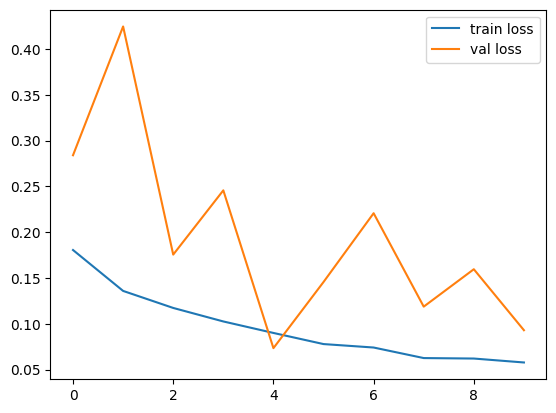

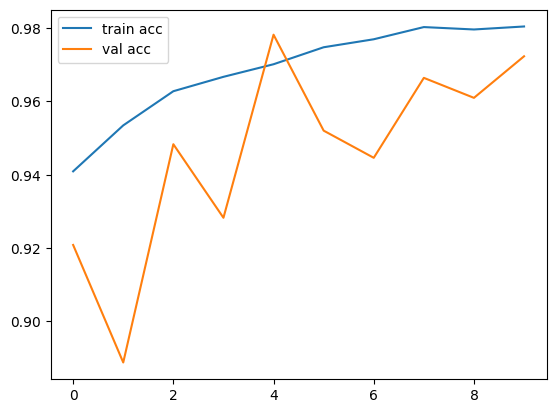

In [34]:
# Plot the Loss and Accuracy
# Loss
plt.plot(resnet152_history.history['loss'], label='train loss')
plt.plot(resnet152_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# Accuracy
plt.plot(resnet152_history.history['accuracy'], label='train acc')
plt.plot(resnet152_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [35]:
class_names = list(train_set.class_indices.keys())
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = resnet152_model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


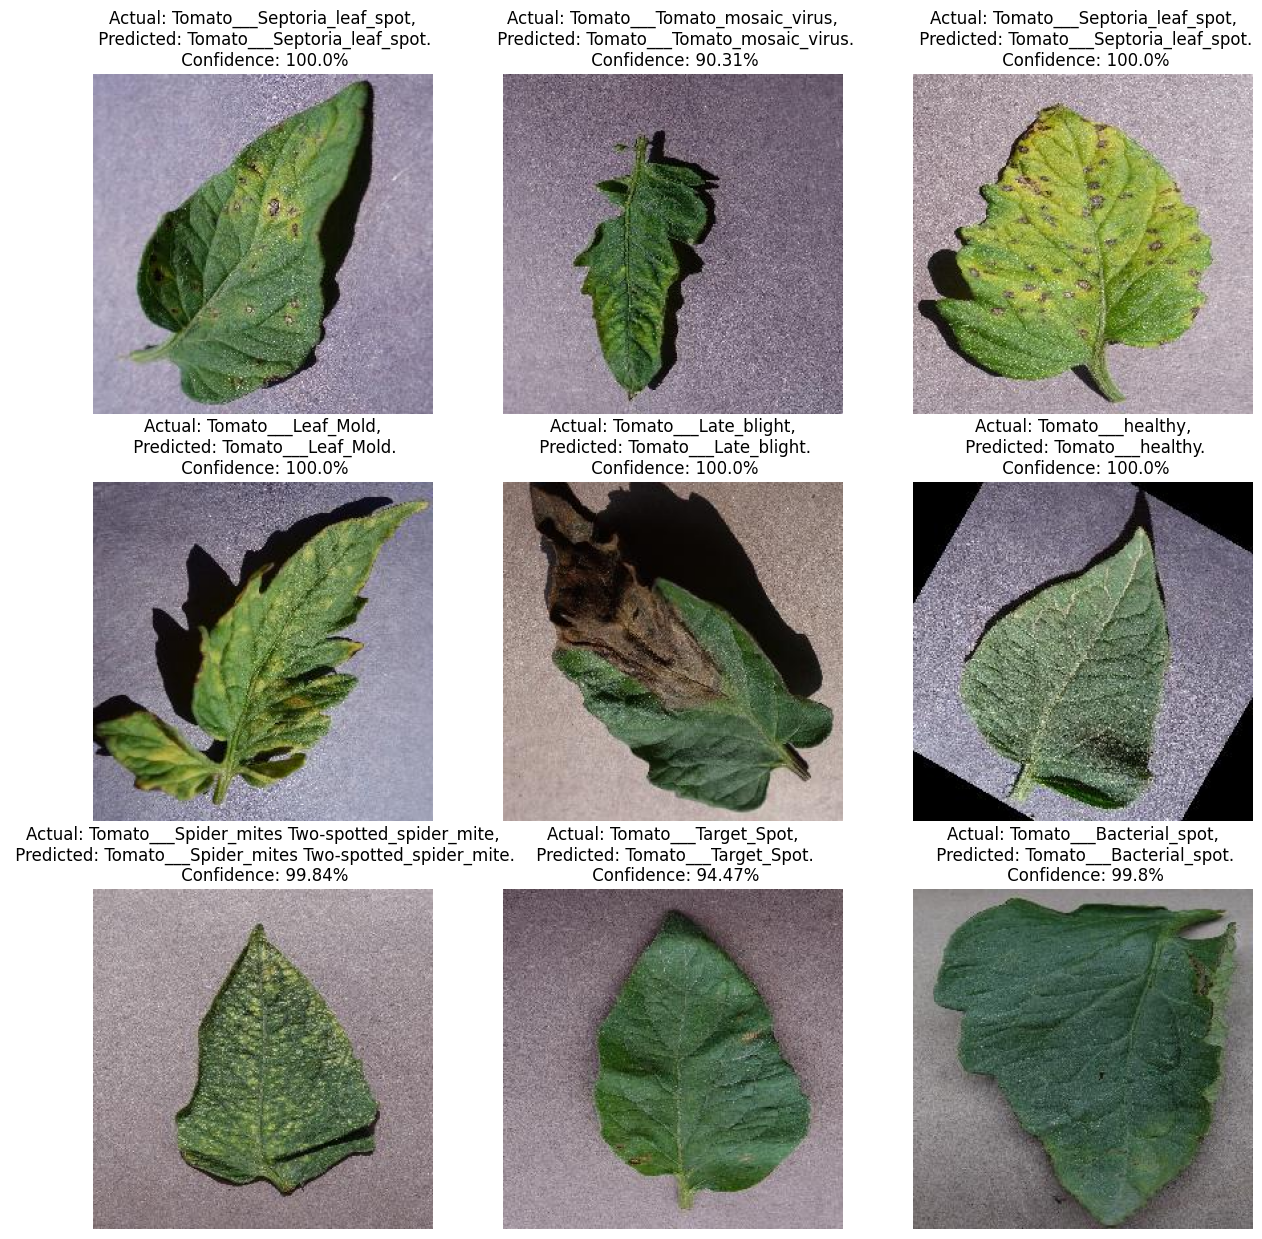

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_set:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        predicted_class, confidence = predict(resnet152_model, images[i])
        index = labels[i].argmax(axis=0)
        actual_class = class_names[index]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
    break


In [38]:
valid_set1 = valid_datagen.flow_from_directory(valid_path,
                                            target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical',
                                             shuffle=False)


Found 4585 images belonging to 10 classes.


In [39]:
Y_pred = resnet152_model.predict(valid_set1, len(valid_set1))
y_pred = np.argmax(Y_pred, axis=1)
y_true = valid_set1.classes
class_names = list(valid_set1.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

144/144 ━━━━━━━━━━━━━━━━━━━━ 45s 249ms/step
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.97      0.99      0.98       425
                        Tomato___Early_blight       0.99      0.95      0.97       480
                         Tomato___Late_blight       0.94      0.98      0.96       463
                           Tomato___Leaf_Mold       1.00      0.96      0.98       470
                  Tomato___Septoria_leaf_spot       0.92      1.00      0.95       436
Tomato___Spider_mites Two-spotted_spider_mite       0.97      0.95      0.96       435
                         Tomato___Target_Spot       0.95      0.95      0.95       457
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00      0.97      0.98       490
                 Tomato___Tomato_mosaic_virus       1.00      0.98      0.99       448
                             Tomato___healthy       0.99      1.00      0.99       48

In [47]:
predicted_class_1, confidence_1 = predict(resnet152_model, '/content/parsha-obyknovennaya1.jpg')
print(predicted_class_1, confidence_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Tomato___Bacterial_spot 99.8


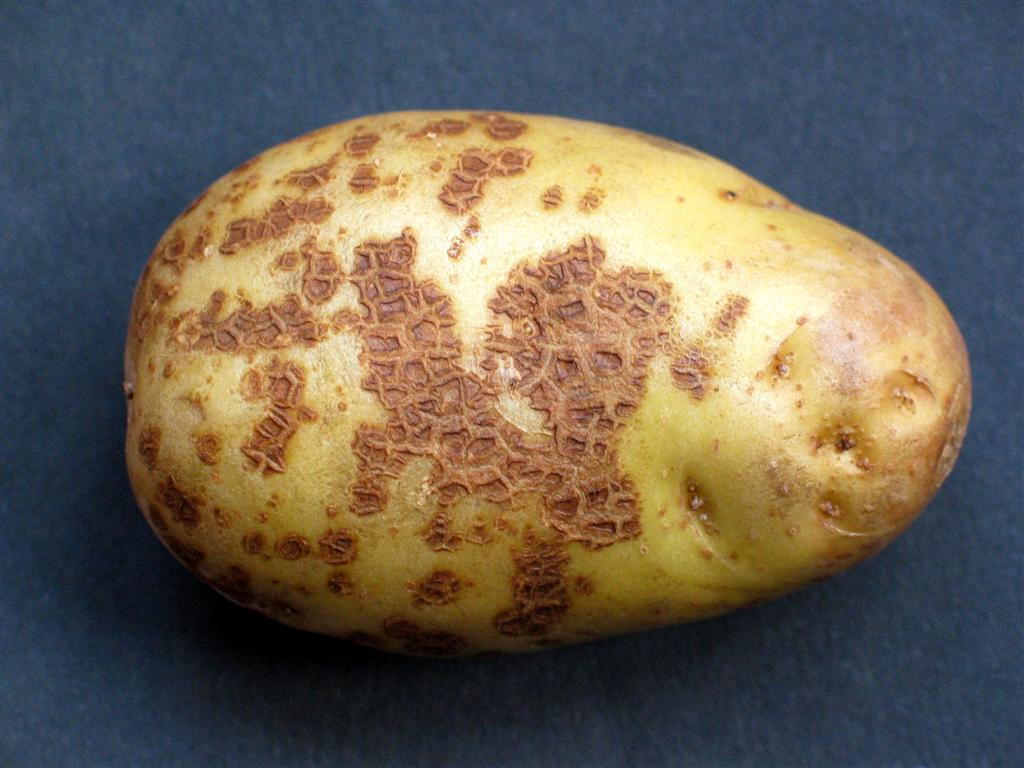

In [48]:
Image(filename='/content/parsha-obyknovennaya1.jpg', width=600)

In [50]:
predicted_class_1, confidence_1 = predict(resnet152_model, '/content/fitoftoroz-botvy-scaled-e1706005467479.jpeg')
print(predicted_class_1, confidence_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tomato___Bacterial_spot 99.8


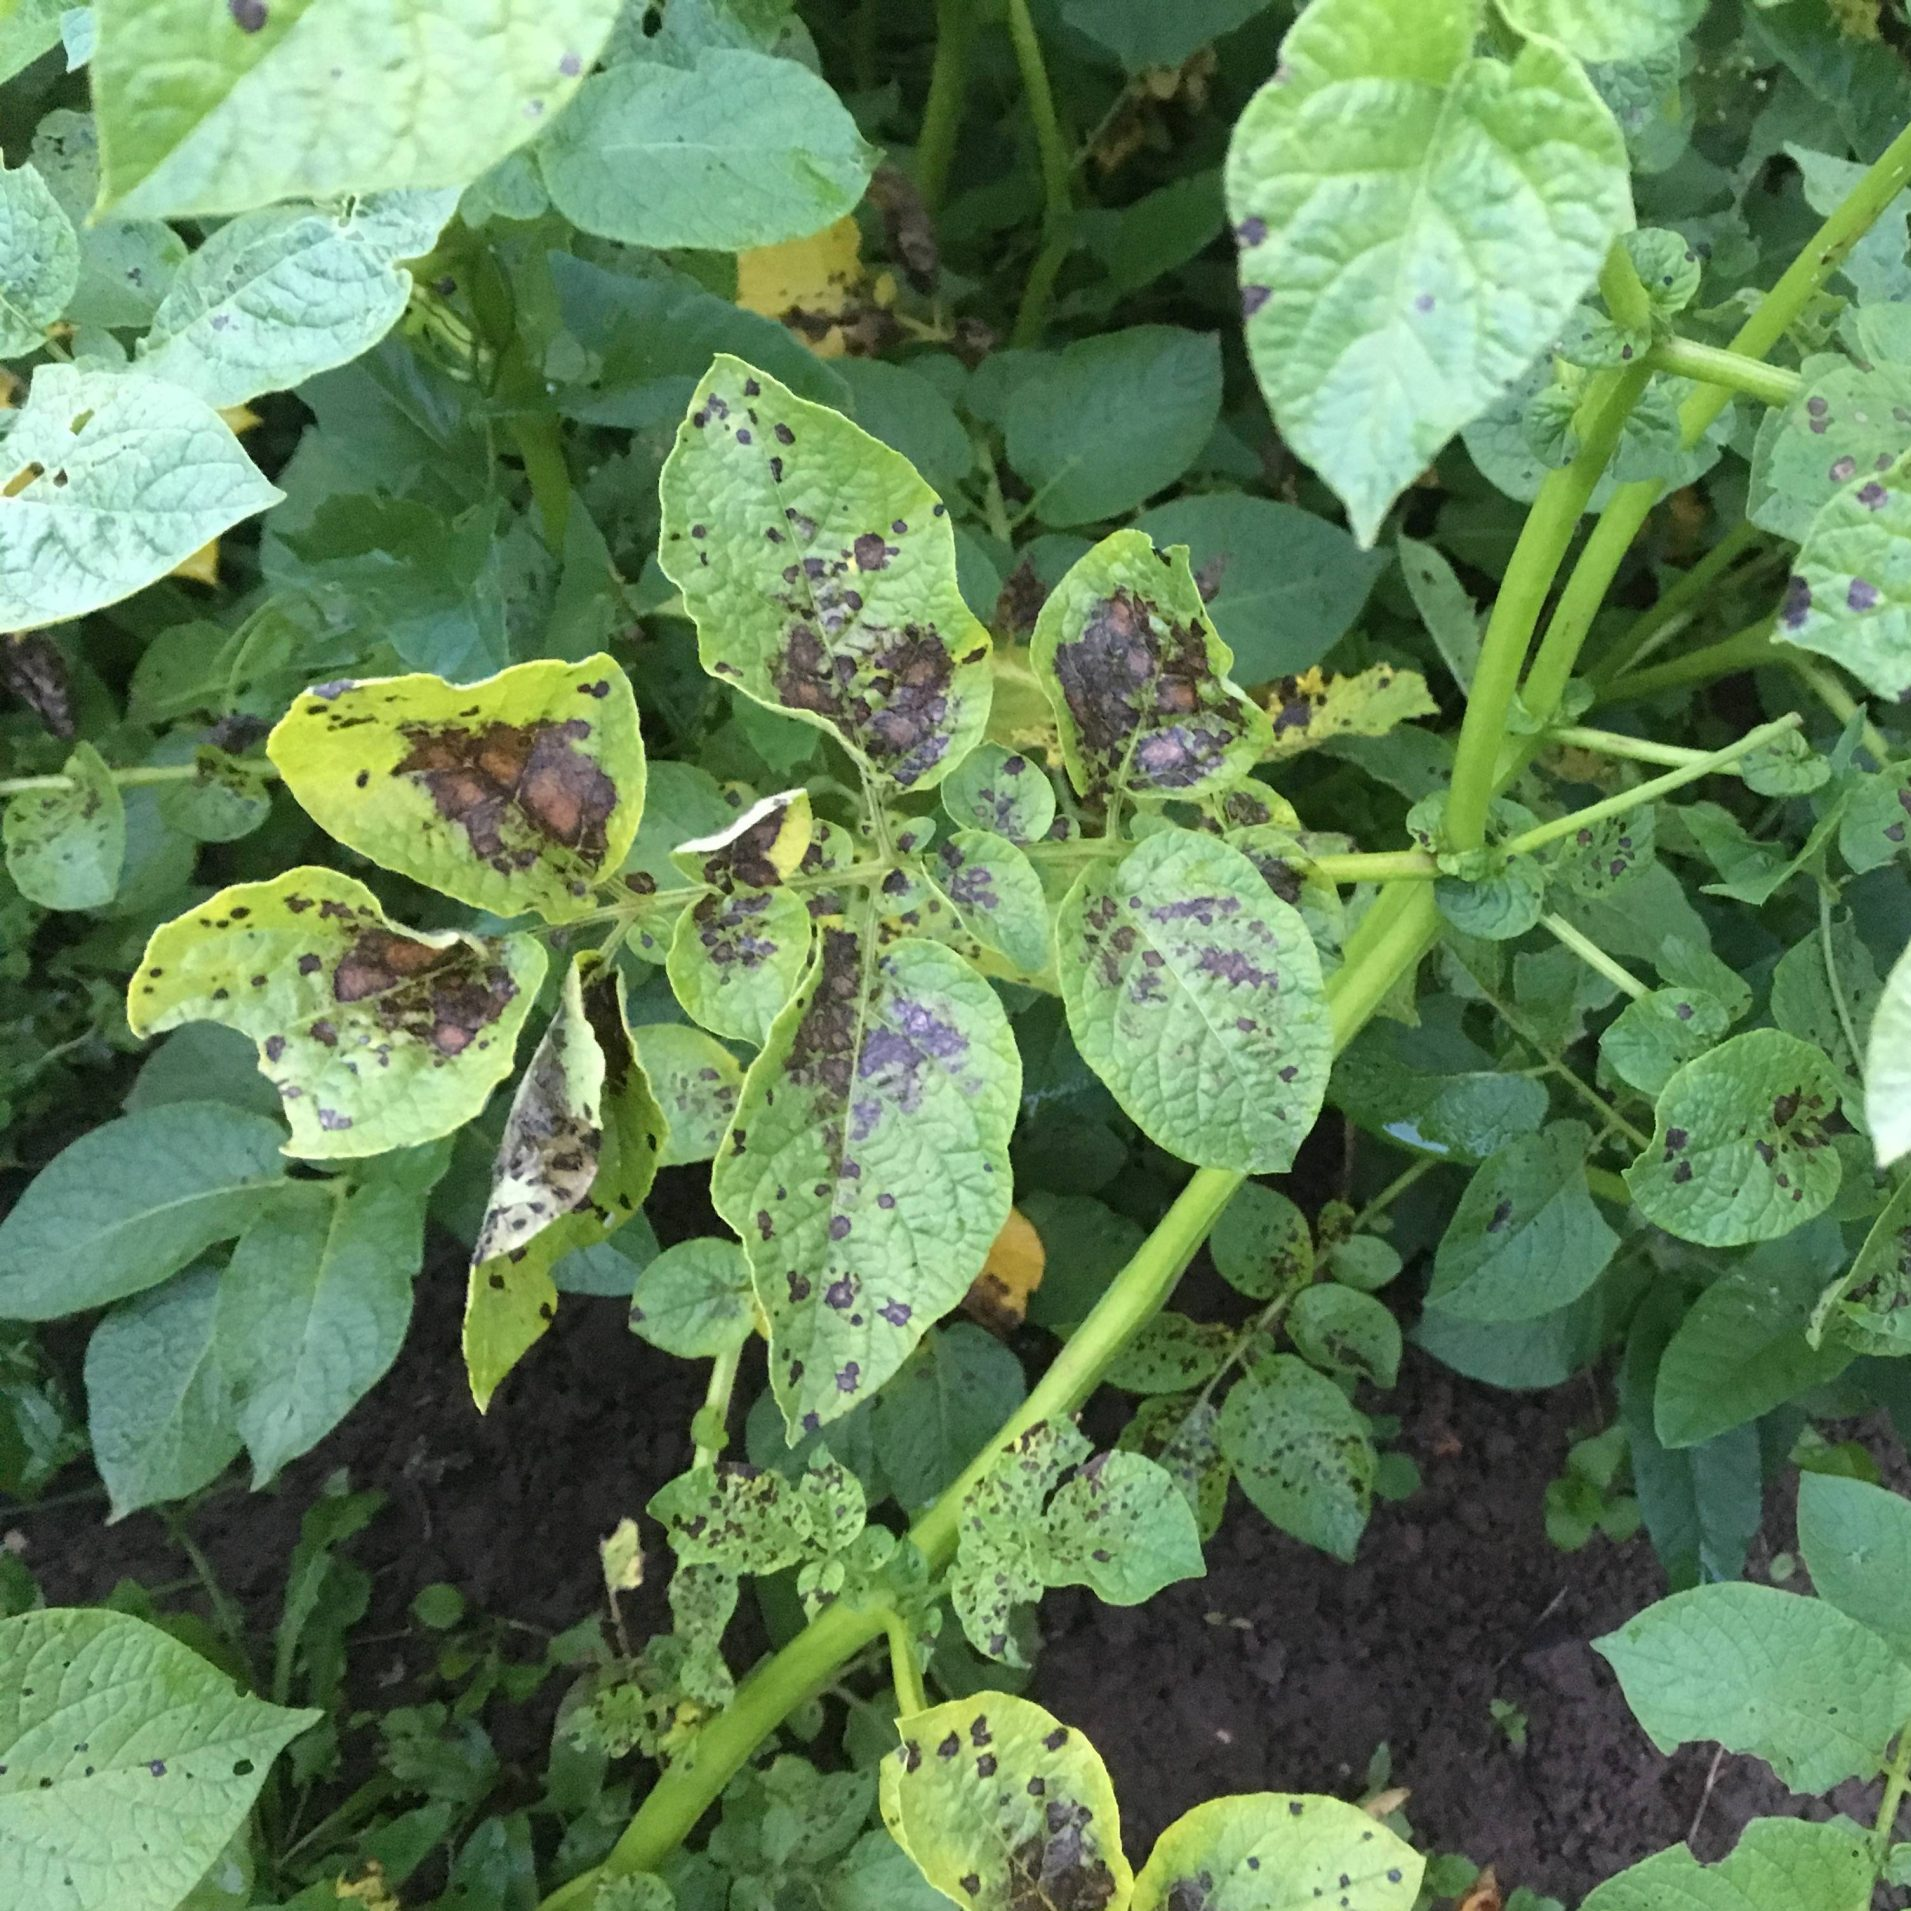

In [51]:
Image(filename='/content/fitoftoroz-botvy-scaled-e1706005467479.jpeg', width=600)

In [52]:
predicted_class_1, confidence_1 = predict(resnet152_model, '/content/fitoftoroz-1.png')
print(predicted_class_1, confidence_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tomato___Bacterial_spot 99.8


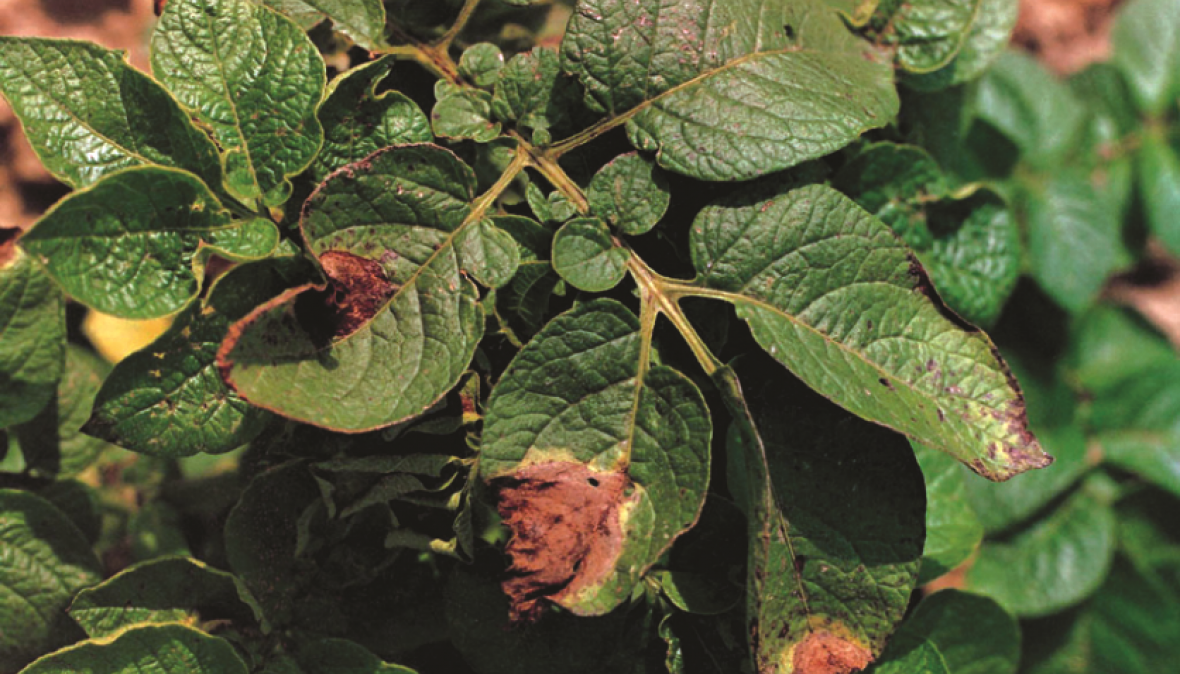

In [53]:
Image(filename='/content/fitoftoroz-1.png', width=600)